# **Final Project_ Task 3 with DP**

Author: Yeonsoo Lim

Libary & setting

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations


# multiple output in notebook without print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


Define CartPoleDynamics Class to set environments and define action and state-update function 

In [158]:
class CartPoleDynamics:
    def __init__(self):
        # System parameters
        self.M = 1.0  # Mass of the cart
        self.m = 0.1  # Mass of the pole
        self.g = -9.8  # Gravity
        self.l = 0.5  # Length of the pole
        self.mu_c = 0.0005  # Friction for the cart
        self.mu_p = 0.000002  # Friction for the pole
        self.delta_t = 0.02  # Time step
        self.actions = [-10, 10]  # Available actions (forces in Newtons)
        
        # State space discretization 
        self.theta_boxes = np.array([-12, -6, -1, 0, 1, 6, 12]) * np.pi / 180  # radians
        self.x_boxes = np.array([-2.4, -0.8, 0.8, 2.4])  # meters
        self.theta_dot_boxes = np.array([-50, 0, 50]) * np.pi / 180  # radians/s
        self.x_dot_boxes = np.array([-0.5, 0, 0.5])  # m/s
        
        # Define state space size (+1 because boxes create one more region than threshold)
        self.state_space_size = (
            len(self.theta_boxes) + 1,
            len(self.theta_dot_boxes) + 1,
            len(self.x_boxes) + 1,
            len(self.x_dot_boxes) + 1
        )

    def compute_accelerations(self, theta, theta_dot, x_dot, F):
        """Compute angular and linear accelerations based on the model."""
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        
        # Calculate angular acceleration (theta_ddot)
        numerator = (self.g * sin_theta + 
                    cos_theta * ((-F - self.m * self.l * theta_dot**2 * sin_theta + 
                                self.mu_c * np.sign(x_dot)) / (self.M + self.m)) - 
                    self.mu_p * theta_dot / (self.m * self.l))
        denominator = self.l * (4.0/3.0 - (self.m * cos_theta**2) / (self.M + self.m))
        theta_ddot = numerator / denominator
        
        # Calculate linear acceleration (x_ddot)
        x_ddot = (F + self.m * self.l * (theta_dot**2 * sin_theta - theta_ddot * cos_theta) - 
                 self.mu_c * np.sign(x_dot)) / (self.M + self.m)
        
        return theta_ddot, x_ddot
    
    def update_state(self, state, action):
        """Update the state using Euler integration"""
        theta, theta_dot, x, x_dot = state
        F = action
        
        theta_ddot, x_ddot = self.compute_accelerations(theta, theta_dot, x_dot, F)
        
        # Update using Euler's method 
        x_dot += self.delta_t * x_ddot
        x += self.delta_t * x_dot
        theta_dot += self.delta_t * theta_ddot
        theta += self.delta_t * theta_dot
        
        return np.array([theta, theta_dot, x, x_dot])
    
    def discretize_state(self, state):
        """Discretize a continuous state based on provided thresholds"""
        theta, theta_dot, x, x_dot = state
        
        theta_idx = np.digitize(theta, self.theta_boxes, right=True)
        theta_dot_idx = np.digitize(theta_dot, self.theta_dot_boxes, right=True)
        x_idx = np.digitize(x, self.x_boxes, right=True)
        x_dot_idx = np.digitize(x_dot, self.x_dot_boxes, right=True)
        
        return (theta_idx, theta_dot_idx, x_idx, x_dot_idx)
        
    def is_state_valid(self, state):
        """Check if the state is within valid bounds"""
        """Here, we follow the 1st scenario of goal and reward given in final project tutorial"""
        theta, _, x, _ = state
        return (abs(theta) <= 12 * np.pi / 180 and abs(x) <= 2.4) # if this is True, the state is valid(not terminated)

Define Dynamic Programming class for Policy Iteration and Value Iteraion Algorithm

In [ ]:
class DynamicProgramming:
    # Use CartPoleDynamics class
    def __init__(self):
        self.dynamics = CartPoleDynamics()
        
    def _compute_state_value(self, state, action, value_function, gamma):
        """Method for computing value function for a state-action pair using Bellman Equation"""
        theta_idx, theta_dot_idx, x_idx, x_dot_idx = state
        
        # Convert discrete state to continuous
        # Assuming deterministic state transitions
        continuous_state = [
            self.dynamics.theta_boxes[theta_idx - 1] if theta_idx > 0 else -np.inf,
            self.dynamics.theta_dot_boxes[theta_dot_idx - 1] if theta_dot_idx > 0 else -np.inf,
            self.dynamics.x_boxes[x_idx - 1] if x_idx > 0 else -np.inf,
            self.dynamics.x_dot_boxes[x_dot_idx - 1] if x_dot_idx > 0 else -np.inf
        ]
        
        # Get next state using dynamics
        next_state_continuous = self.dynamics.update_state(continuous_state, action)
        next_state = self.dynamics.discretize_state(next_state_continuous)
        
        # Compute reward based on state validity
        reward = 1 if self.dynamics.is_state_valid(next_state_continuous) else 0
        
        # Compute value using Bellman equation
        return reward + gamma * value_function[next_state]
        
    """ Policy Iteration Algorithm"""    
    def policy_iteration(self, gamma = 0.95, threshold = 1e-4):
        # Initialize policy randomly (0: -10N, 1: 10N)
        policy = np.random.choice([0, 1], size = self.dynamics.state_space_size)
        # Initialize value functioni to zeros
        value_function = np.zeros(self.dynamics.state_space_size)
        """ Policy iteration consists of two alternating phases(evaluation and improvement)"""
        while True:
            # Policy Evaluation
            while True:
                delta = 0 # Track maximum change in value
                # Iterate through all states
                for theta_idx in range(self.dynamics.state_space_size[0]):
                    for theta_dot_idx in range(self.dynamics.state_space_size[1]):
                        for x_idx in range(self.dynamics.state_space_size[2]):
                            for x_dot_idx in range(self.dynamics.state_space_size[3]):
                                state = (theta_idx, theta_dot_idx, x_idx, x_dot_idx)
                                # Get action from current policy
                                action = self.dynamics.actions[policy[state]]
                                value = value_function[state]
                                # Compute new value using '_compute_state_value' method(Bellman equation)
                                new_value = self._compute_state_value(state, action, value_function, gamma)
                                value_function[state] = new_value
                                # Update maximum change
                                delta = max(delta, abs(value - new_value))
                                
                # Check if value function has converged, if converged then break the loop
                if delta < threshold:
                    break
            
            # Policy Improvement
            policy_stable = True
            # Iterate through all states
            for theta_idx in range(self.dynamics.state_space_size[0]):
                for theta_dot_idx in range(self.dynamics.state_space_size[1]):
                    for x_idx in range(self.dynamics.state_space_size[2]):
                        for x_dot_idx in range(self.dynamics.state_space_size[3]):
                            state = (theta_idx, theta_dot_idx, x_idx, x_dot_idx)
                            old_action = policy[state]
                            
                            # Find best action
                            action_values = []
                            # Iterate through all possible action
                            for action in self.dynamics.actions:
                                value = self._compute_state_value(state, action, value_function, gamma)
                                action_values.append(value)
                            
                            best_action = np.argmax(action_values)
                            policy[state] = best_action
                            
                            if old_action != best_action:
                                policy_stable = False
            # if policy_stable is False(meaning we found better action at least one state) then begin policy evaluation loop again 
            if policy_stable:
                break
                
        return policy, value_function
    
    ### Value Iteration Algorithm
    def value_iteration(self, gamma = 0.95, threshold = 1e-4):
        """ Updating Value function and action at the same time """
        # Initialize policy and value functions
        value_function = np.zeros(self.dynamics.state_space_size)
        policy = np.zeros(self.dynamics.state_space_size, dtype = int)
        
        while True:
            delta = 0 # Track maximum change in value
            for theta_idx in range(self.dynamics.state_space_size[0]):
                for theta_dot_idx in range(self.dynamics.state_space_size[1]):
                    for x_idx in range(self.dynamics.state_space_size[2]):
                        for x_dot_idx in range(self.dynamics.state_space_size[3]):
                            state = (theta_idx, theta_dot_idx, x_idx, x_dot_idx)
                            value = value_function[state]
                            
                            # Find maximum value over all actions
                            action_values = []
                            for action in self.dynamics.actions:
                                # Compute new value using '_compute_state_value' method(Bellman equation)
                                new_value = self._compute_state_value(state, action, value_function, gamma)
                                action_values.append(new_value)
                                
                            # Update value function with maximum value
                            value_function[state] = max(action_values)
                            # Update policy with best action
                            policy[state] = np.argmax(action_values)
                            # Update maximum change
                            delta = max(delta, abs(value - value_function[state]))
                                        
            if delta < threshold:
                break
                
        return policy, value_function
    
    # Function for Plotting
    def plot_results(self, policy, value_function, method_name, fixed_theta_dot_idx, fixed_x_dot_idx):
        """Plot value function and policy for a given slice of state space"""
        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot value function
        # Extract 2D slice of the 4D value function and policy
        # We fix theta_dot and x_dot and plot theta versus x
        value_slice = value_function[:, fixed_theta_dot_idx, :, fixed_x_dot_idx]
        # plot value function
        im1 = ax1.imshow(value_slice, extent=[self.dynamics.x_boxes[0], 
                                            self.dynamics.x_boxes[-1],
                                            self.dynamics.theta_boxes[0],
                                            self.dynamics.theta_boxes[-1]],
                        aspect='auto', origin='lower', cmap='coolwarm')
        plt.colorbar(im1, ax=ax1, label='Value')
        ax1.set_title(f'Value Function ({method_name})')
        ax1.set_xlabel('Cart Position (x) [m]')
        ax1.set_ylabel('Pole Angle (θ) [rad]')
        
        # Plot policy
        policy_slice = policy[:, fixed_theta_dot_idx, :, fixed_x_dot_idx]
        im2 = ax2.imshow(policy_slice, extent=[self.dynamics.x_boxes[0],
                                             self.dynamics.x_boxes[-1],
                                             self.dynamics.theta_boxes[0],
                                             self.dynamics.theta_boxes[-1]],
                        aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(im2, ax=ax2, label='Action Index')
        ax2.set_title(f'Policy ({method_name})')
        ax2.set_xlabel('Cart Position (x) [m]')
        ax2.set_ylabel('Pole Angle (θ) [rad]')
        
        plt.tight_layout()
        plt.show()

## Implementation
def main():
    # Create instance of DP solver
    dp = DynamicProgramming()
    
    # Run policy iteration
    pi_policy, pi_value = dp.policy_iteration()
    
    # Run value iteration
    vi_policy, vi_value = dp.value_iteration()
    
    # Plot results for both methods
    # Different combinations of theta_dot and x_dot
    fixed_states = [(0, 0), (1, 0), (2, 0)]    
    for theta_dot_idx, x_dot_idx in fixed_states:
        # Plot policy iteration results
        dp.plot_results(pi_policy, pi_value, f"Policy Iteration with θ_dot: {dp.dynamics.theta_dot_boxes[theta_dot_idx]*180/np.pi}(degree, {dp.dynamics.theta_dot_boxes[theta_dot_idx]:2f} rad), x_dot: {dp.dynamics.x_dot_boxes[x_dot_idx]}", theta_dot_idx, x_dot_idx)
        
        # Plot value iteration results
        dp.plot_results(vi_policy, vi_value, f"Value Iteration with θ_dot: {dp.dynamics.theta_dot_boxes[theta_dot_idx]*180/np.pi}(degree, {dp.dynamics.theta_dot_boxes[theta_dot_idx]:.2f} rad), x_dot: {dp.dynamics.x_dot_boxes[x_dot_idx]}", theta_dot_idx, x_dot_idx)
        
    # Printing value functions
    #print(f'Value functions from Policy Iteration: \n \
    #      {pi_value} \n' )
    
    #print(f'Value functions from Value Iteration: \n \
    #      {vi_value}')

Implementing Algorithms

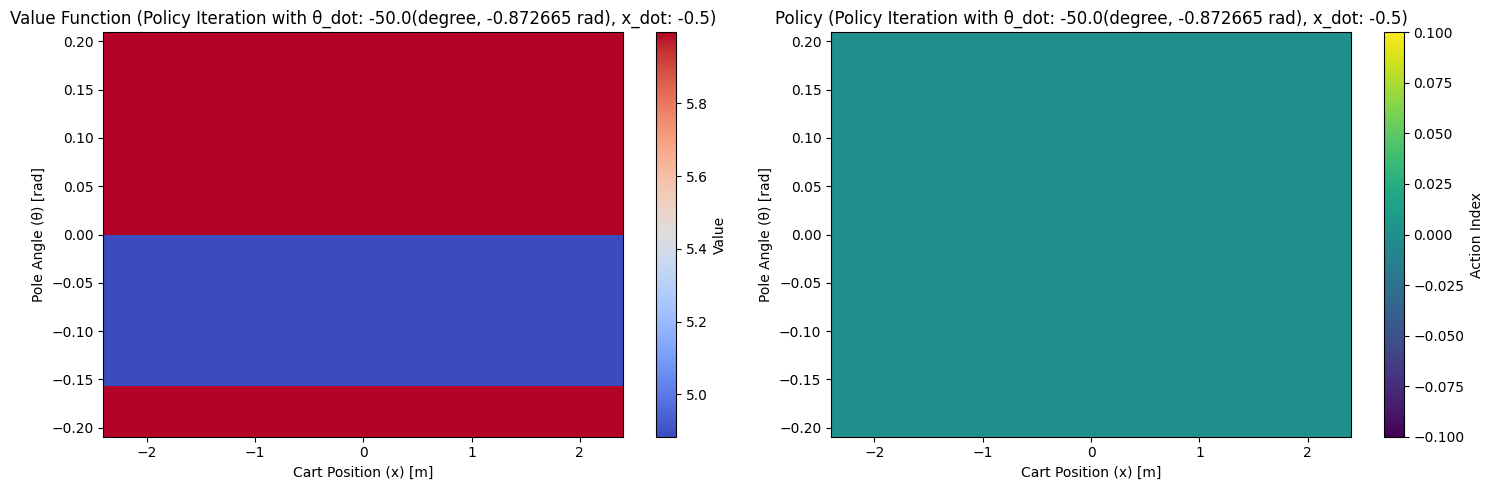

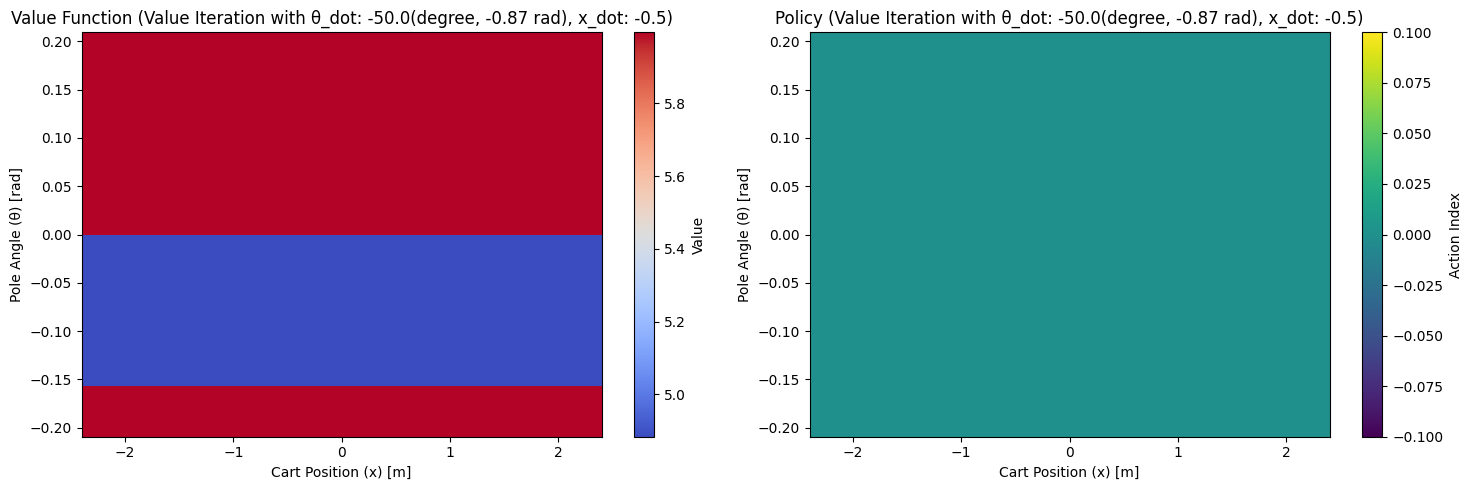

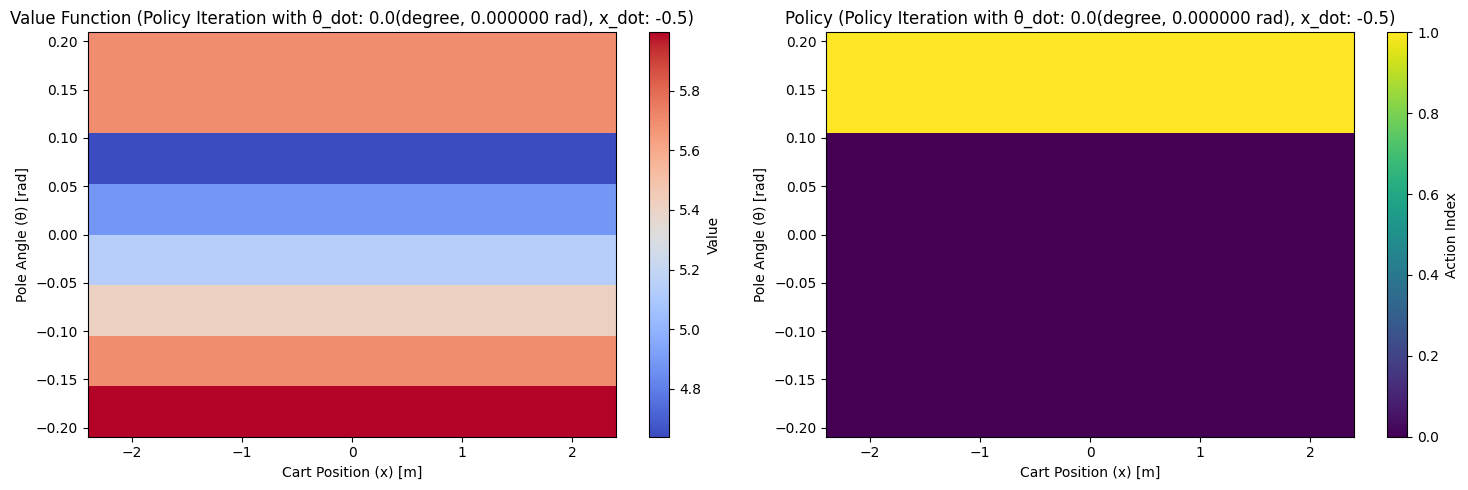

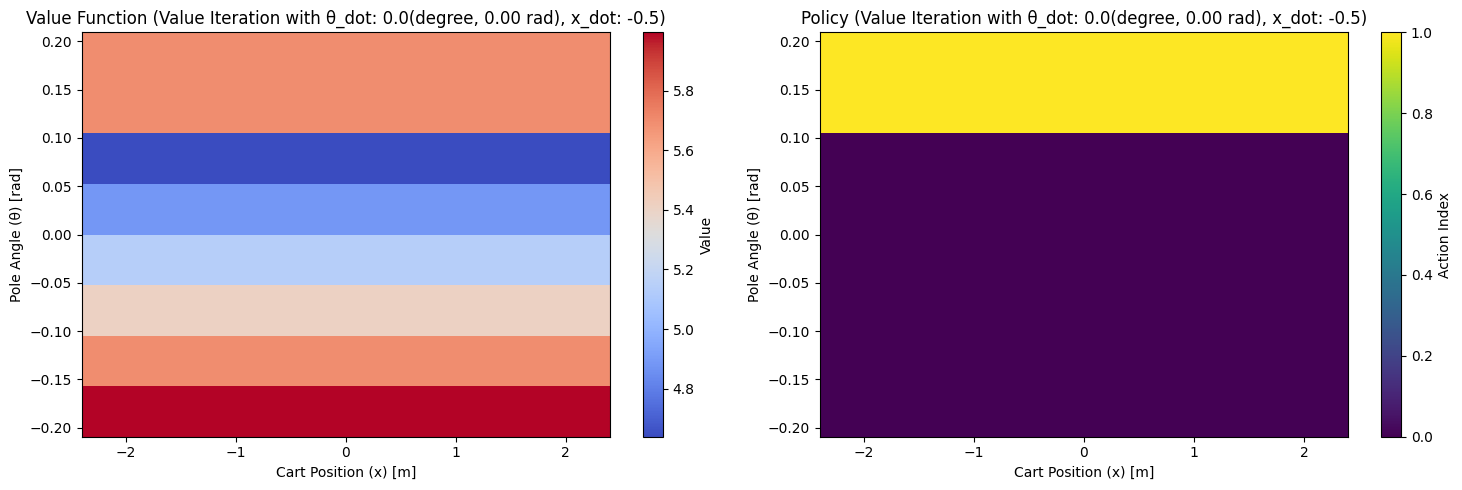

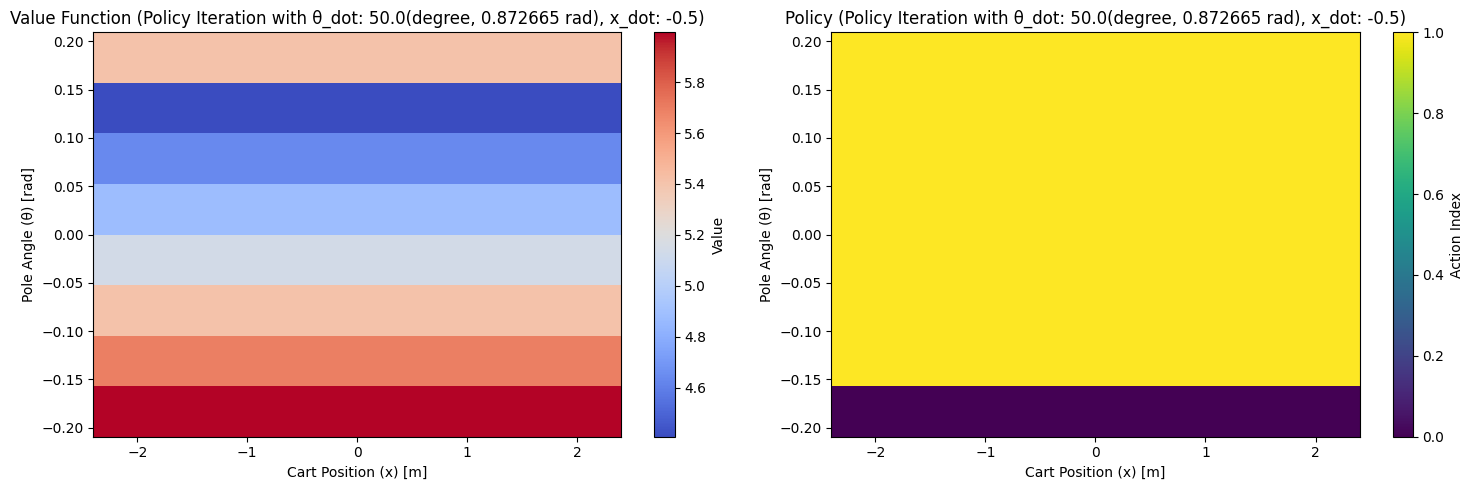

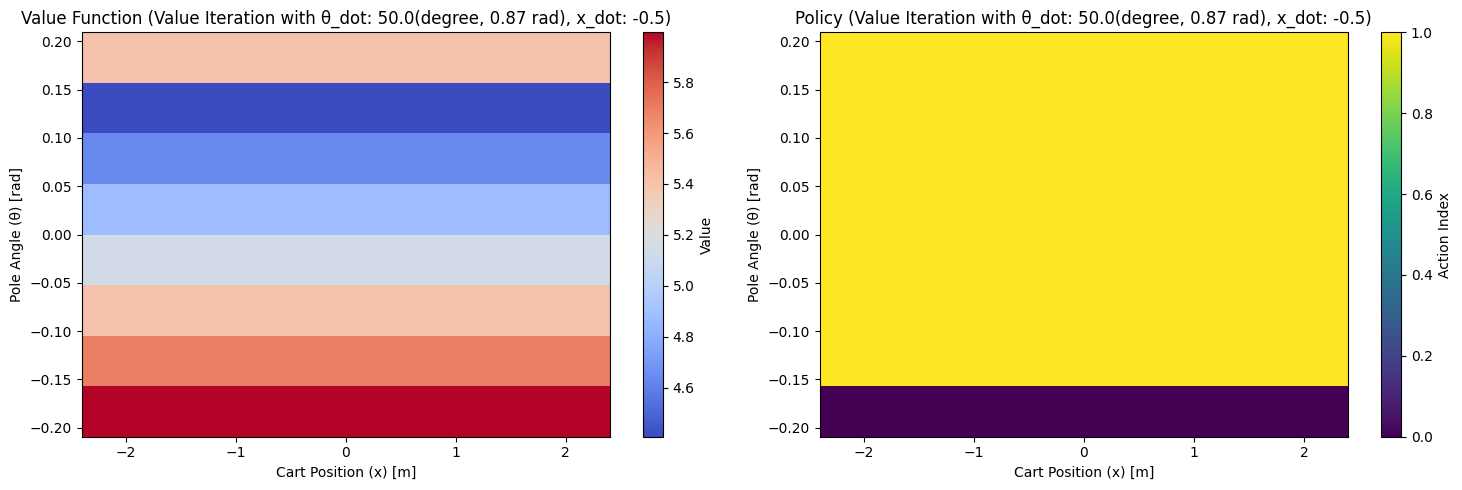

In [167]:
### Algorithm Implementation and Plotting
if __name__ == "__main__":
    main()
    